In [1]:
## import os

from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.nn.functional as F
import torch.distributed as dist
from torch import optim
from torch.autograd import Variable
from collections import deque
import random
import copy
import os

In [2]:
# env.close()
env = UnityEnvironment(file_name="Tennis.app", no_graphics=False, seed=1)
# env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size # 2
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1] # 24
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.63803244 -1.5
 -0.          0.          6.00063038  6.         -0.          0.        ]


In [5]:
from collections import namedtuple
# class ReplayBuffer:
#     def __init__(self, action_size, buffer_size, batch_size, seed):
#         self.action_size = action_size
#         self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
#         self.batch_size = batch_size
#         self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
# #         self.seed = random.seed(seed)
    
#     def add(self, state, action, reward, next_state, done):
#         e = self.experience(state, action, reward, next_state, done)
#         self.memory.append(e)
    
#     def sample(self):
#         """Randomly sample a batch of experiences from memory."""
#         experiences = random.sample(self.memory, k=self.batch_size)

#         states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
#         actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float()
#         rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
#         next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
#         dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()

#         return (states, actions, rewards, next_states, dones)

#     def __len__(self):
#         """Return the current size of internal memory."""
#         return len(self.memory)
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
dim_actor_in = state_size
dim_actor_h1 = 256
dim_actor_h2 = 128
dim_actor_out = action_size

action_dim = action_size * num_agents
dim_critic_in = num_agents * state_size
dim_critic_h1 = 256
dim_critic_h2 = 128
dim_critic_out = 1

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.size = size
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(dim_actor_in, dim_actor_h1)
        self.bn1 = nn.BatchNorm1d(dim_actor_h1)
        self.fc2 = nn.Linear(dim_actor_h1, dim_actor_h2)
        self.bn2 = nn.BatchNorm1d(dim_actor_h2)
        self.fc3 = nn.Linear(dim_actor_h2, dim_actor_out)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        h1 = f.relu(
                self.fc1(state))
        h2 = f.relu(
                self.fc2(h1))
        out = self.fc3(h2)
        return torch.tanh(out)
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(dim_critic_in, dim_critic_h1)
        self.bn1 = nn.BatchNorm1d(dim_critic_h1)
        self.fc2 = nn.Linear(dim_critic_h1+action_dim, dim_critic_h2)
        self.bn2 = nn.BatchNorm1d(dim_critic_h2)
        self.fc3 = nn.Linear(dim_critic_h2, dim_critic_out)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        h1 = f.relu(
                self.fc1(state))
        hi = torch.cat((h1, 
                        action), dim=1)
        h2 = f.relu(self.fc2(hi))
        out = self.fc3(h2)
        return out

In [7]:
class Agent:
    def __init__(self, a_id):
        self.a_id = a_id
        self.actor_local = Actor()
        self.actor_target = Actor()
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=lr_actor)
        
        self.critic_local = Critic()
        self.critic_target = Critic()
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=lr_critic)
        
        self.tau = tau
        self.replay_buffer = ReplayBuffer(action_size, buffer_size=buffer_size, batch_size=batch_size, seed=random.random())
        self.noise = OUNoise(action_size, random.random())
        
    def reset(self):
        self.noise.reset()
        
    def act(self, state, ep_num):
        if self.a_id == 0:
            state = state[:, :state_size]
        else:
            state = state[:, state_size:]
        state = torch.from_numpy(state).float()
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).data.numpy()
        self.actor_local.train()
        # Apply noise every other episode
        if ep_num < 200 or ep_num % 2 == 0:
            action += (1 - min(ep_num/600., 1)) * self.noise.sample()
        np.clip(action, -1, 1)
        return action
    def train(self):
        if len(self.replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = self.replay_buffer.sample()
            if self.a_id == 0:
                actions_future = torch.cat(
                    (self.actor_target(next_states[:, :state_size]), actions[:,2:]),
                    dim=1)
            else:
                actions_future = torch.cat(
                    (actions[:,:2], self.actor_target(next_states[:, state_size:])),
                    dim=1)
            Q_future = self.critic_target(next_states, actions_future)
            Q_targets = rewards + (gamma * Q_future * (1-dones))
            Q_expected = self.critic_local(states, actions)
            critic_loss = F.mse_loss(Q_expected, Q_targets)
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            if self.a_id == 0:
                actions_pred = torch.cat(
                    (self.actor_local(states[:,:state_size]), actions[:,2:]),
                    dim=1)
            else:
                actions_pred = torch.cat(
                    (actions[:,:2], self.actor_local(states[:,state_size:])),
                    dim=1)
            actor_loss = -self.critic_local(states, actions_pred).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            self.soft_update()

        
    def _update_actor(self):
        for target_param, local_param in zip(self.actor_target.parameters(), self.actor_local.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
    def _update_critic(self):
        for target_param, local_param in zip(self.critic_target.parameters(), self.critic_local.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def soft_update(self):
        self._update_critic()
        self._update_actor()



In [8]:
num_episodes = 1200
buffer_size = int(1e6)
batch_size = 256
num_agents = 2
gamma = 0.999

tau = 7e-3
lr_actor = 1e-3
lr_critic = 1e-3
train_every=1

# seed = 2

In [9]:
# # Collection of agents
epoch = 0
solved = False
for epc in range(5000):
    if solved:
        break
    scores = np.array([]) 
    max_score = 0
    max_avg = 0
    agent0=Agent(a_id=0)
    agent1 = Agent(a_id=1)
    for ep_num in range(num_episodes):
        agent0.reset()
        agent1.reset()
        ep_scores = np.zeros(num_agents)
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        states = np.reshape(states, (1,48))
        t=0
        while True:
            t+=1 
            action0 = agent0.act(states, ep_num)
            action1 = agent1.act(states, ep_num)
            actions = np.concatenate((action0, action1), axis=0)
            actions = np.reshape(actions, (1,4))
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            next_states = np.reshape(next_states, (1, 48))
            rewards = env_info.rewards
            dones = env_info.local_done
            agent0.replay_buffer.add(states, actions, rewards[0], next_states, dones[0])
            agent1.replay_buffer.add(states, actions, rewards[1], next_states, dones[1])
            agent0.train()
            agent1.train()

            # Environment Rules take the max of the agents as the "episode score"
            ep_scores += rewards
            states = next_states
            if sum(dones) > 0:
                break
        ep_score = np.max(ep_scores)
        max_score = max(max_score, ep_score)
        scores = np.append(scores, ep_score)
        avg_score = np.mean(scores[-100:])
        if ep_num > 100:
            max_avg = max(max_avg, avg_score)
        if avg_score > 0.5:
            solved = True
            print("SOLVED IN {} EPISODES".format(ep_num))
            torch.save(agent0.actor_local.state_dict(), 'checkpoint_actor0_final.pth')
            torch.save(agent0.critic_local.state_dict(), 'checkpoint_critic0_final.pth')
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor1_final.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic1_final.pth')
            break
        os.write(1, "\rEPISODE={}\tSCORE={:.3f}\tAVG={:.3f}\tMAX_SCORE={:.3f}\tMAX_AVG={:.3f}".format(
            ep_num, ep_score, avg_score, max_score, max_avg).encode())
        if ep_num % 10 == 0:
            print("\rEPISODE={}:{}\tSCORE={:.3f}\tAVG={:.3f}\tMAX_SCORE={:.3f}\tMAX_AVG={:.3f}".format(
                ep_num,t, ep_score, avg_score, max_score, max_avg), end="")
        if ep_num > 500 and avg_score < 0.03:
            print("EPOCH {} failed".format(epc))
            print("+++++++++++++")
            break


EPISODE=1160:53	SCORE=0.100	AVG=0.450	MAX_SCORE=2.600	MAX_AVG=0.4557SOLVED IN 1168 EPISODES


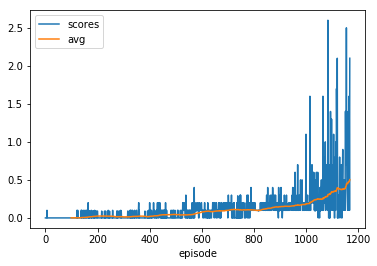

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
p_scores = [(i, score) for i, score in enumerate(scores)]
scores_df = pd.DataFrame.from_records(data=p_scores, columns=['episode', 'scores'], index='episode')
scores_df['avg'] = scores_df.rolling(window=100).mean()

scores_df.plot()

In [ ]:
def movingaverage(interval, window_size):
    window= numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')